In [1]:
#Import the required packages

import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
#import plotly.express as px
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve
import time
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
CarAuction_df= pd.read_csv('CarAuction.csv')

In [3]:
CarAuction_df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [4]:
CarAuction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [5]:
CarAuction_df.isnull().values.any()

True

In [6]:
CarAuction_df.isnull().sum()

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentA

In [7]:
print("To check for duplicate data : ")
print("-----------------------------")
display(CarAuction_df.duplicated().sum())

display(CarAuction_df.loc[CarAuction_df.duplicated(), :])

To check for duplicate data : 
-----------------------------


0

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


# Split the dataset into train and test

In [8]:
# input Features
X = CarAuction_df.drop(['IsBadBuy'], axis=1)
# output or target
y = CarAuction_df['IsBadBuy']

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1, stratify = y)

In [10]:
CarAuction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

# Data Cleaning and Feature Engineering

In [11]:
X_train=X_train.drop(X_train.columns[[0]], axis=1)
X_test=X_test.drop(X_test.columns[[0]], axis=1)

In [12]:
#to print the categorical fields : Train set
X_train.select_dtypes(include=['object']).columns.tolist()

['PurchDate',
 'Auction',
 'Make',
 'Model',
 'Trim',
 'SubModel',
 'Color',
 'Transmission',
 'WheelType',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'PRIMEUNIT',
 'AUCGUART',
 'VNST']

In [13]:
#to print the categorical fields : Test set
X_test.select_dtypes(include=['object']).columns.tolist()

['PurchDate',
 'Auction',
 'Make',
 'Model',
 'Trim',
 'SubModel',
 'Color',
 'Transmission',
 'WheelType',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'PRIMEUNIT',
 'AUCGUART',
 'VNST']

In [14]:
print("Print distinct categorical value (Train set):")

print("Make.value_counts:",len(X_train.PurchDate.value_counts(dropna=False)))
print("PurchDate.value_counts:",len(X_train.Make.value_counts(dropna=False)))
print("Model.value_counts:",len(X_train.Model.value_counts(dropna=False)))
print("Trim.value_counts:",len(X_train.Trim.value_counts(dropna=False)))
print("SubModel.value_counts:",len(X_train.SubModel.value_counts(dropna=False)))
print("Color.value_counts:",len(X_train.Color.value_counts(dropna=False)))
print("Transmission.value_counts:",len(X_train.Transmission.value_counts(dropna=False)))
print("WheelType.value_counts:",len(X_train.WheelType.value_counts(dropna=False)))
print("Nationality.value_counts:",len(X_train.Nationality.value_counts(dropna=False)))
print("Size.value_counts:",len(X_train.Size.value_counts(dropna=False)))
print("TopThreeAmericanName.value_counts:",len(X_train.TopThreeAmericanName.value_counts(dropna=False)))
print("PRIMEUNIT.value_counts:",len(X_train.PRIMEUNIT.value_counts(dropna=False)))
print("AUCGUART.value_counts:",len(X_train.AUCGUART.value_counts(dropna=False)))
print("VNST.value_counts:",len(X_train.VNST.value_counts(dropna=False)))
print("WheelTypeID.value_counts:",len(X_train.WheelTypeID.value_counts(dropna=False)))
#print("IsOnlineSale.value_counts:",len(X_train.IsOnlineSale.value_counts(dropna=False)))

Print distinct categorical value (Train set):
Make.value_counts: 517
PurchDate.value_counts: 33
Model.value_counts: 1042
Trim.value_counts: 133
SubModel.value_counts: 841
Color.value_counts: 17
Transmission.value_counts: 4
WheelType.value_counts: 4
Nationality.value_counts: 5
Size.value_counts: 13
TopThreeAmericanName.value_counts: 5
PRIMEUNIT.value_counts: 3
AUCGUART.value_counts: 3
VNST.value_counts: 37
WheelTypeID.value_counts: 5


In [15]:
print("Print distinct categorical value (Test Set):")

print("Make.value_counts:",len(X_test.PurchDate.value_counts(dropna=False)))
print("PurchDate.value_counts:",len(X_test.Make.value_counts(dropna=False)))
print("Model.value_counts:",len(X_test.Model.value_counts(dropna=False)))
print("Trim.value_counts:",len(X_test.Trim.value_counts(dropna=False)))
print("SubModel.value_counts:",len(X_test.SubModel.value_counts(dropna=False)))
print("Color.value_counts:",len(X_test.Color.value_counts(dropna=False)))
print("Transmission.value_counts:",len(X_test.Transmission.value_counts(dropna=False)))
print("WheelType.value_counts:",len(X_test.WheelType.value_counts(dropna=False)))
print("Nationality.value_counts:",len(X_test.Nationality.value_counts(dropna=False)))
print("Size.value_counts:",len(X_test.Size.value_counts(dropna=False)))
print("TopThreeAmericanName.value_counts:",len(X_test.TopThreeAmericanName.value_counts(dropna=False)))
print("PRIMEUNIT.value_counts:",len(X_test.PRIMEUNIT.value_counts(dropna=False)))
print("AUCGUART.value_counts:",len(X_test.AUCGUART.value_counts(dropna=False)))
print("VNST.value_counts:",len(X_test.VNST.value_counts(dropna=False)))
print("WheelTypeID.value_counts:",len(X_train.WheelTypeID.value_counts(dropna=False)))
#print("IsOnlineSale.value_counts:",len(X_train.IsOnlineSale.value_counts(dropna=False)))

Print distinct categorical value (Test Set):
Make.value_counts: 510
PurchDate.value_counts: 30
Model.value_counts: 743
Trim.value_counts: 110
SubModel.value_counts: 560
Color.value_counts: 17
Transmission.value_counts: 3
WheelType.value_counts: 4
Nationality.value_counts: 4
Size.value_counts: 12
TopThreeAmericanName.value_counts: 4
PRIMEUNIT.value_counts: 3
AUCGUART.value_counts: 3
VNST.value_counts: 37
WheelTypeID.value_counts: 5


# -- Handling the Categorical field for one Hot Encoding

In [16]:
print("for train set:")
print(X_train.Make.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.Make.value_counts(dropna=False))

for train set:
CHEVROLET       13826
DODGE           10262
FORD             8994
CHRYSLER         7108
PONTIAC          3413
KIA              1974
SATURN           1709
NISSAN           1703
HYUNDAI          1468
JEEP             1298
SUZUKI           1071
TOYOTA            917
MITSUBISHI        824
MAZDA             806
MERCURY           734
BUICK             560
GMC               521
HONDA             415
OLDSMOBILE        193
VOLKSWAGEN        112
ISUZU             105
SCION              99
LINCOLN            82
INFINITI           33
VOLVO              30
ACURA              28
CADILLAC           28
LEXUS              26
SUBARU             24
MINI               19
PLYMOUTH            2
TOYOTA SCION        1
HUMMER              1
Name: Make, dtype: int64
------------------------------------------
for test set:
CHEVROLET     3422
DODGE         2650
FORD          2311
CHRYSLER      1736
PONTIAC        845
KIA            510
SATURN         454
NISSAN         382
JEEP           346
HYUNDA

In [17]:
print("for train set:")
print(X_train.Transmission.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.Transmission.value_counts(dropna=False))

for train set:
AUTO      56301
MANUAL     2077
NaN           7
Manual        1
Name: Transmission, dtype: int64
------------------------------------------
for test set:
AUTO      14097
MANUAL      498
NaN           2
Name: Transmission, dtype: int64


In [18]:
X_train["Transmission"].replace("Manual","MANUAL",inplace=True)
X_train.Transmission.value_counts(dropna=False)

AUTO      56301
MANUAL     2078
NaN           7
Name: Transmission, dtype: int64

In [19]:
print("for train set:")
print(X_train.WheelType.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.WheelType.value_counts(dropna=False))

for train set:
Alloy      28821
Covers     26393
NaN         2556
Special      616
Name: WheelType, dtype: int64
------------------------------------------
for test set:
Alloy      7229
Covers     6611
NaN         618
Special     139
Name: WheelType, dtype: int64


In [20]:
print("for train set:")
print(X_train.WheelTypeID.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.WheelTypeID.value_counts(dropna=False))

for train set:
1.0    28821
2.0    26393
NaN     2552
3.0      616
0.0        4
Name: WheelTypeID, dtype: int64
------------------------------------------
for test set:
1.0    7229
2.0    6611
NaN     617
3.0     139
0.0       1
Name: WheelTypeID, dtype: int64


In [21]:
print("for train set:")
print(X_train.Nationality.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.Nationality.value_counts(dropna=False))

for train set:
AMERICAN          48727
OTHER ASIAN        6462
TOP LINE ASIAN     3031
OTHER               161
NaN                   5
Name: Nationality, dtype: int64
------------------------------------------
for test set:
AMERICAN          12301
OTHER ASIAN        1571
TOP LINE ASIAN      691
OTHER                34
Name: Nationality, dtype: int64


In [22]:
print("for train set:")
print(X_train.Size.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.Size.value_counts(dropna=False))

for train set:
MEDIUM         24657
LARGE           7064
MEDIUM SUV      6456
COMPACT         5732
VAN             4693
LARGE TRUCK     2543
SMALL SUV       1821
SPECIALTY       1556
CROSSOVER       1381
LARGE SUV       1158
SMALL TRUCK      710
SPORTS           610
NaN                5
Name: Size, dtype: int64
------------------------------------------
for test set:
MEDIUM         6128
LARGE          1786
MEDIUM SUV     1634
COMPACT        1473
VAN            1161
LARGE TRUCK     627
SMALL SUV       455
CROSSOVER       378
SPECIALTY       359
LARGE SUV       275
SPORTS          167
SMALL TRUCK     154
Name: Size, dtype: int64


In [23]:
print("for train set:")
print(X_train.Model.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.Model.value_counts(dropna=False))

for train set:
PT CRUISER              1881
IMPALA                  1602
TAURUS                  1160
CALIBER                 1097
CARAVAN GRAND FWD V6    1005
                        ... 
RONDO 4C 2.4L I4 DI        1
SEQUOIA 4WD 4.7L V8        1
ODYSSEY 3.5L V6 MPI        1
AVALON 3.0L V6 EFI D       1
SUBURBAN 2500 4WD          1
Name: Model, Length: 1042, dtype: int64
------------------------------------------
for test set:
PT CRUISER              448
IMPALA                  388
CARAVAN GRAND FWD V6    284
CALIBER                 278
TAURUS                  265
                       ... 
EXPLORER 2WD V8           1
ENTOURAGE                 1
MARINER 2WD 4C 2.3L       1
LE SABRE 3.8L V6 MPI      1
2500 RAM PICKUP 4WD       1
Name: Model, Length: 743, dtype: int64


In [24]:
print("for train set:")
print(X_train.Trim.value_counts(dropna=False))
print("------------------------------------------")
print("for test set:")
print(X_test.Trim.value_counts(dropna=False))

for train set:
Bas    11226
LS      8133
SE      7442
SXT     3025
LT      2823
       ...  
Xsp        1
L 3        1
Har        1
JLX        1
LL         1
Name: Trim, Length: 133, dtype: int64
------------------------------------------
for test set:
Bas    2724
LS     2041
SE     1906
SXT     800
LT      717
       ... 
Z24       1
Ent       1
C         1
Spe       1
ZX2       1
Name: Trim, Length: 110, dtype: int64


We can make certain conclusions observing the dataset is that:
1. VNST : displays the state from where the vehicle was bought, which doesnt contribute in deciding the good or bad buy, hence dropping it.
2. Both WheelType and WheelTypeID are same, so lets drop numeric field WheelTypeID, and retain the wheelType since it gives better description of the metal.
3. Since PurchDate, VehYear and VehicleAge all help us understand the age of the vehicle and hol old the manufacturing was, so lets reatin just the VehicleAge and drop other two columns.

In [25]:
X_train.drop(['PurchDate','VehYear','WheelTypeID','VNST','Model','SubModel','Trim'],axis=1,inplace=True)
X_test.drop(['PurchDate','VehYear','WheelTypeID','VNST','Model','SubModel','Trim'],axis=1,inplace=True)
print(X_train.info())
print("------------------------------\n")
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58386 entries, 55611 to 65226
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Auction                            58386 non-null  object 
 1   VehicleAge                         58386 non-null  int64  
 2   Make                               58386 non-null  object 
 3   Color                              58380 non-null  object 
 4   Transmission                       58379 non-null  object 
 5   WheelType                          55830 non-null  object 
 6   VehOdo                             58386 non-null  int64  
 7   Nationality                        58381 non-null  object 
 8   Size                               58381 non-null  object 
 9   TopThreeAmericanName               58381 non-null  object 
 10  MMRAcquisitionAuctionAveragePrice  58372 non-null  float64
 11  MMRAcquisitionAuctionCleanPrice    58372 non-null 

Identifying the Categorical and Numerical Value to handle the missing and null values seperatly

In [26]:
Train_categorical_cols = X_train.select_dtypes(include = 'object').columns.tolist()
Train_numeric_cols = X_train.select_dtypes(exclude='object').columns.tolist()
Test_categorical_cols = X_test.select_dtypes(include = 'object').columns.tolist()
Test_numeric_cols = X_test.select_dtypes(exclude='object').columns.tolist()

Substituting the missing values of the numeric columns with the mean of the column

In [27]:
imputer=SimpleImputer(strategy='mean');
imputer.fit(X_train[Train_numeric_cols]);
#imputer.fit(CarAuction_df[Test_numeric_cols]);
X_train[Train_numeric_cols]=imputer.transform(X_train[Train_numeric_cols]);
X_test[Test_numeric_cols]=imputer.transform(X_test[Test_numeric_cols]);
print(X_train.head())
print("--------------------------------------------------")
print(X_test.head())

       Auction  VehicleAge       Make  Color Transmission WheelType   VehOdo  \
55611    OTHER         2.0      DODGE  BLACK         AUTO    Covers  47611.0   
8063   MANHEIM         3.0  CHEVROLET  WHITE         AUTO    Covers  68422.0   
69095    ADESA         4.0       FORD   GREY         AUTO    Covers  76902.0   
58863  MANHEIM         6.0  CHEVROLET   BLUE         AUTO    Covers  88852.0   
11431  MANHEIM         2.0  CHEVROLET   GREY         AUTO    Covers  77714.0   

      Nationality       Size TopThreeAmericanName  ...  \
55611    AMERICAN     MEDIUM             CHRYSLER  ...   
8063     AMERICAN      LARGE                   GM  ...   
69095    AMERICAN  LARGE SUV                 FORD  ...   
58863    AMERICAN    COMPACT                   GM  ...   
11431    AMERICAN     MEDIUM                   GM  ...   

       MMRCurrentAuctionCleanPrice  MMRCurrentRetailAveragePrice  \
55611                       8544.0                       11123.0   
8063                        9340.0

Substituting the null values of the categorical columns with the unknown value

In [28]:
df=pd.DataFrame(X_train.isna().sum())
df.rename({0:'counts'},axis=1,inplace=True)
df[(df.counts>0)]

,counts
Color,6
Transmission,7
WheelType,2556
Nationality,5
Size,5
TopThreeAmericanName,5
PRIMEUNIT,55656
AUCGUART,55656


In [29]:
#X_train.Trim.fillna('Trim_unk',inplace=True)
#X_train.SubModel.fillna('SubModel_unk',inplace=True)
X_train.Color.fillna('Color_unk',inplace=True)
X_train.Transmission.fillna('Trans_unk',inplace=True)
X_train.WheelType.fillna('WheelType_unk',inplace=True)
X_train.Nationality.fillna('Nationality_unk',inplace=True)
X_train.Size.fillna('Trans_unk',inplace=True)
X_train.TopThreeAmericanName.fillna('TopThreeAmericanName_unk',inplace=True)
X_train.PRIMEUNIT.fillna('PRIMEUNIT_unk',inplace=True)
X_train.AUCGUART.fillna('AUCGUART_unk',inplace=True)

In [30]:
X_train.isnull().sum()

Auction                              0
VehicleAge                           0
Make                                 0
Color                                0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
PRIMEUNIT                            0
AUCGUART                             0
BYRNO                                0
VNZIP1                               0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

In [31]:
df=pd.DataFrame(X_test.isna().sum())
df.rename({0:'counts'},axis=1,inplace=True)
df[(df.counts>0)]

,counts
Color,2
Transmission,2
WheelType,618
PRIMEUNIT,13908
AUCGUART,13908


In [32]:
#X_test.Trim.fillna('Trim_unk',inplace=True)
#X_test.SubModel.fillna('SubModel_unk',inplace=True)
X_test.Color.fillna('Color_unk',inplace=True)
X_test.Transmission.fillna('Trans_unk',inplace=True)
X_test.WheelType.fillna('WheelType_unk',inplace=True)
X_test.PRIMEUNIT.fillna('PRIMEUNIT_unk',inplace=True)
X_test.AUCGUART.fillna('AUCGUART_unk',inplace=True)

In [33]:
X_test.isnull().sum()

Auction                              0
VehicleAge                           0
Make                                 0
Color                                0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
PRIMEUNIT                            0
AUCGUART                             0
BYRNO                                0
VNZIP1                               0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

# Exploratory Data Analysis

Count of Bad Buy vs Good Buy in our training data

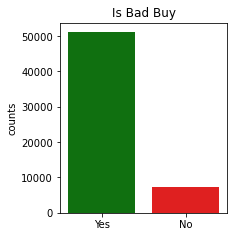

In [34]:
comparison=y_train.value_counts()
plt.figure(figsize=(3,3.5))
sns.barplot(x=['Yes','No'],y=comparison,palette=['g','r'])
plt.ylabel('counts')
plt.title("Is Bad Buy")
plt.show()

Age of Vehicle with respect to the count of vehicles with the same age

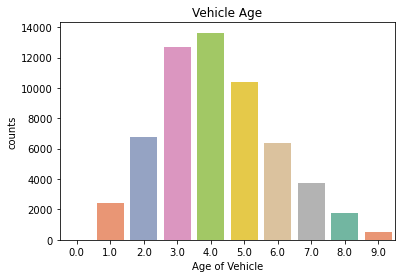

In [35]:
vehicle_age=pd.DataFrame(X_train.VehicleAge.value_counts())
plt.figure(figsize=(6,4))
sns.barplot(x=vehicle_age.index,y='VehicleAge',data=vehicle_age,palette='Set2')
plt.ylabel('counts')
plt.xlabel('Age of Vehicle')
plt.title("Vehicle Age")
plt.show()

# One Hot Encoding

Train Dataset

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(X_train[Train_categorical_cols])
encoded_cols=list(encoder.get_feature_names(Train_categorical_cols))
X_train[encoded_cols]=encoder.transform(X_train[Train_categorical_cols])
X_test[encoded_cols]=encoder.transform(X_test[Test_categorical_cols])

In [37]:
X_train=X_train[Train_numeric_cols+encoded_cols]

In [38]:
X_train.head()

,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,...,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,TopThreeAmericanName_TopThreeAmericanName_unk,PRIMEUNIT_NO,PRIMEUNIT_PRIMEUNIT_unk,PRIMEUNIT_YES,AUCGUART_AUCGUART_unk,AUCGUART_GREEN,AUCGUART_RED
55611,2.0,47611.0,7876.0,8746.0,11888.0,12665.0,7634.0,8544.0,11123.0,12032.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8063,3.0,68422.0,7109.0,8224.0,10418.0,11976.0,8173.0,9340.0,12037.0,13156.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
69095,4.0,76902.0,10412.0,12013.0,11745.0,13474.0,10629.0,12631.0,11979.0,14141.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
58863,6.0,88852.0,2362.0,3438.0,3051.0,4213.0,2387.0,3336.0,3078.0,4103.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
11431,2.0,77714.0,10472.0,11550.0,13858.0,15135.0,10406.0,11814.0,14043.0,15371.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [39]:
X_test.columns

Index(['Auction', 'VehicleAge', 'Make', 'Color', 'Transmission', 'WheelType',
       'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       ...
       'TopThreeAmericanName_FORD', 'TopThreeAmericanName_GM',
       'TopThreeAmericanName_OTHER',
       'TopThreeAmericanName_TopThreeAmericanName_unk', 'PRIMEUNIT_NO',
       'PRIMEUNIT_PRIMEUNIT_unk', 'PRIMEUNIT_YES', 'AUCGUART_AUCGUART_unk',
       'AUCGUART_GREEN', 'AUCGUART_RED'],
      dtype='object', length=114)

Test Dataset

In [40]:
X_test=X_test[Test_numeric_cols+encoded_cols]

In [41]:
X_test.head()

,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,...,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,TopThreeAmericanName_TopThreeAmericanName_unk,PRIMEUNIT_NO,PRIMEUNIT_PRIMEUNIT_unk,PRIMEUNIT_YES,AUCGUART_AUCGUART_unk,AUCGUART_GREEN,AUCGUART_RED
44311,6.0,71958.0,4584.0,5625.0,8060.0,8970.0,3872.0,5168.0,7249.0,8764.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
21434,4.0,57072.0,7174.0,8352.0,10402.0,11637.0,6838.0,8217.0,10418.0,12426.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
29154,1.0,46188.0,6733.0,7195.0,7772.0,8271.0,7240.0,7737.0,8319.0,8856.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9693,4.0,73666.0,7131.0,8559.0,8201.0,9744.0,7131.0,8559.0,8201.0,9744.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
27528,6.0,93440.0,5048.0,6564.0,5952.0,7589.0,4777.0,6022.0,8289.0,10048.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [42]:
X_test.columns

Index(['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice',
       ...
       'TopThreeAmericanName_FORD', 'TopThreeAmericanName_GM',
       'TopThreeAmericanName_OTHER',
       'TopThreeAmericanName_TopThreeAmericanName_unk', 'PRIMEUNIT_NO',
       'PRIMEUNIT_PRIMEUNIT_unk', 'PRIMEUNIT_YES', 'AUCGUART_AUCGUART_unk',
       'AUCGUART_GREEN', 'AUCGUART_RED'],
      dtype='object', length=104)

# Modeling Without Feature Selection

In [43]:
Result = pd.DataFrame(columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"])
#Result = Result.astype({'Accuracy Score': np.float,'F1 Score': np.float,'Precision Score': np.float,'Recall Score': np.float,'AUC': np.float,'Kappa Score': np.float,})
Result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Model            0 non-null      object
 1   Accuracy Score   0 non-null      object
 2   F1 Score         0 non-null      object
 3   Precision Score  0 non-null      object
 4   Recall Score     0 non-null      object
 5   AUC              0 non-null      object
 6   Kappa Score      0 non-null      object
dtypes: object(7)
memory usage: 0.0+ bytes


# Decision Tree

In [44]:
start=time.time()
tree=DecisionTreeClassifier(max_depth=12,random_state=42)
tree.fit(X_train, y_train)
stop=time.time()
dt_tt = round((stop-start) / 60, 2)
print(f"Training time: {dt_tt}min")

Training time: 0.02min


In [45]:
y_pred_dt = tree.predict(X_test)

In [46]:
#Confusion Matrix
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_dt),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12574,228
True[1],1380,415


In [47]:
#Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred_dt))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12802
           1       0.65      0.23      0.34      1795

    accuracy                           0.89     14597
   macro avg       0.77      0.61      0.64     14597
weighted avg       0.87      0.89      0.87     14597



In [48]:
y_pred_p_dt = tree.predict_proba(X_test)
y_pred_p_dt = y_pred_p_dt[:, 1]
auc = roc_auc_score(y_test, y_pred_p_dt)

Accuracy=metrics.accuracy_score(y_test, y_pred_dt)
F1_Score=metrics.f1_score(y_test, y_pred_dt)
precision= metrics.precision_score(y_test, y_pred_dt)
recall=metrics.recall_score(y_test, y_pred_dt)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_dt)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 0, values=['Decision Tree',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8898403781598959
F1 Score: 0.34044298605414275
Precision Score: 0.645412130637636
Recall Score: 0.23119777158774374
AUC: 70.18%
Kappa Score: 0.29469352491214007


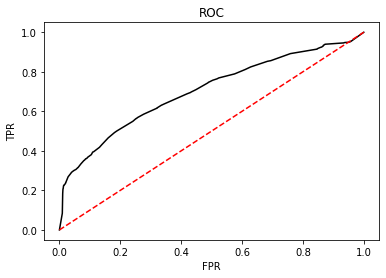

In [49]:
fpr,tpr,thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

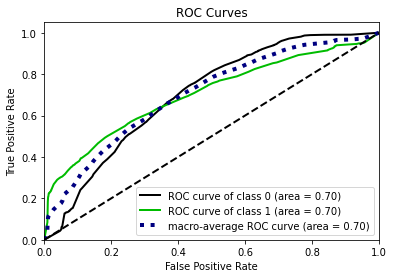

In [50]:
skplt.metrics.plot_roc(y_test, tree.predict_proba(X_test), plot_micro=False)
plt.show()

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

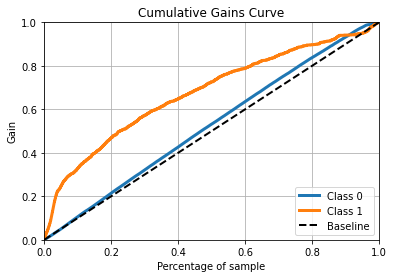

In [51]:
skplt.metrics.plot_cumulative_gain(y_test, tree.predict_proba(X_test))

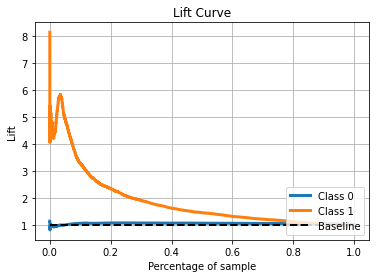

In [52]:
skplt.metrics.plot_lift_curve(y_test, tree.predict_proba(X_test))
plt.show()

# Random Forest

In [53]:
start=time.time()
forest = RandomForestClassifier( max_depth = 4, n_estimators = 500)
forest.fit(X_train, y_train)
stop=time.time()
rf_tt = round((stop-start) / 60, 2)
print(f"Training time: {rf_tt}min")

Training time: 0.34min


In [54]:
y_pred_rc = forest.predict(X_test)

In [55]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_rc),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],12802,0
True[1],1793,2


In [56]:
#Classification Report
print('Classification Report of Random Forest Classifier')
print(classification_report(y_test, y_pred_rc))

Classification Report of Random Forest Classifier
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12802
           1       1.00      0.00      0.00      1795

    accuracy                           0.88     14597
   macro avg       0.94      0.50      0.47     14597
weighted avg       0.89      0.88      0.82     14597



In [57]:
y_pred_p_rc = forest.predict_proba(X_test)
y_pred_p_rc = y_pred_p_rc[:, 1]
auc = roc_auc_score(y_test, y_pred_p_rc)

Accuracy=metrics.accuracy_score(y_test, y_pred_rc)
F1_Score=metrics.f1_score(y_test, y_pred_rc)
precision= metrics.precision_score(y_test, y_pred_rc)
recall=metrics.recall_score(y_test, y_pred_rc)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_rc)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 1, values=['Random Forest',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8771665410700829
F1 Score: 0.0022259321090706734
Precision Score: 1.0
Recall Score: 0.0011142061281337048
AUC: 73.24%
Kappa Score: 0.0019527426962911987


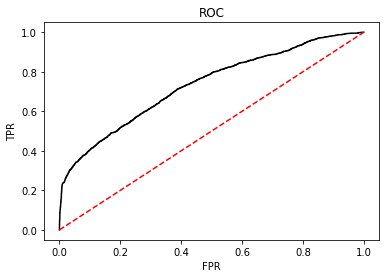

In [58]:
fpr,tpr,thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

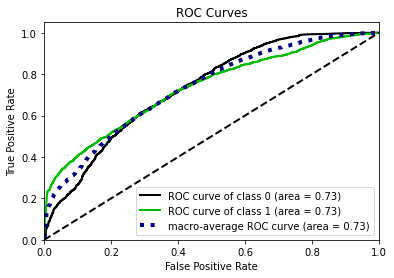

In [59]:
skplt.metrics.plot_roc(y_test, forest.predict_proba(X_test), plot_micro=False)
plt.show()

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

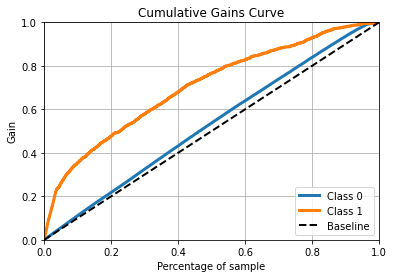

In [60]:
skplt.metrics.plot_cumulative_gain(y_test, forest.predict_proba(X_test))

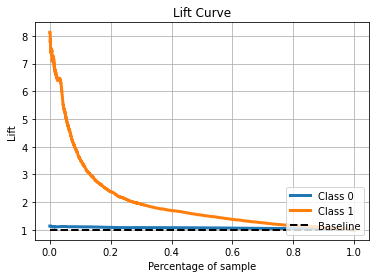

In [61]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(X_test))
plt.show()

# Logistic Regression

In [62]:
start=time.time()
logistic = LogisticRegression(solver = 'liblinear', penalty = 'l2',C =0.001, random_state = 1)
logistic.fit(X_train, y_train)
stop=time.time()
lr_tt = round((stop-start) / 60, 2)
print(f"Training time: {lr_tt}min")

Training time: 0.02min


In [63]:
y_pred_lr = logistic.predict(X_test)

In [64]:
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_lr),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12802,0
True[1],1795,0


In [65]:
#Classification Report
print('Classification Report of Logistic Regression')
print(classification_report(y_test, y_pred_lr))

Classification Report of Logistic Regression
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12802
           1       0.00      0.00      0.00      1795

    accuracy                           0.88     14597
   macro avg       0.44      0.50      0.47     14597
weighted avg       0.77      0.88      0.82     14597



In [66]:
y_pred_p_lr = logistic.predict_proba(X_test)
y_pred_p_lr = y_pred_p_lr[:, 1]
auc = roc_auc_score(y_test, y_pred_p_lr)


Accuracy=metrics.accuracy_score(y_test, y_pred_lr)
F1_Score=metrics.f1_score(y_test, y_pred_lr)
precision= metrics.precision_score(y_test, y_pred_lr)
recall=metrics.recall_score(y_test, y_pred_lr)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_lr)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 2, values=['Logistic Regression',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8770295266150578
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
AUC: 61.89%
Kappa Score: 0.0


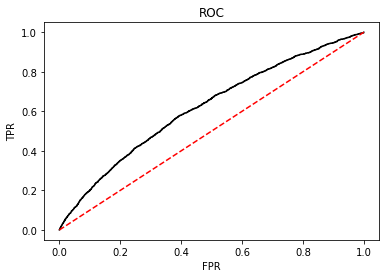

In [67]:
fpr,tpr,thresholds = roc_curve(y_test, logistic.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

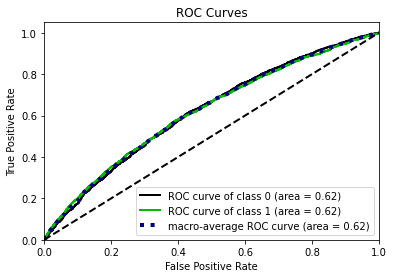

In [68]:
skplt.metrics.plot_roc(y_test, logistic.predict_proba(X_test), plot_micro=False)
plt.show()

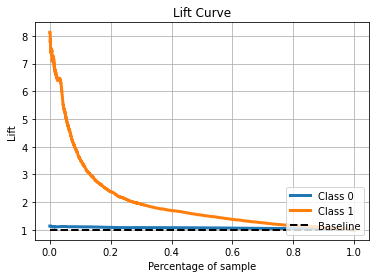

In [69]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(X_test))
plt.show()

# Naive Bayes Classifier

In [70]:
start=time.time()
gnb= GaussianNB(priors = [0.5,0.5])
gnb.fit(X_train, y_train)
stop=time.time()
nb_tt = round((stop-start) / 60, 2)
print(f"Training time: {nb_tt}min")

Training time: 0.0min


In [71]:
y_pred_gnb = gnb.predict(X_test)

In [72]:
y_pred_p_gnb = gnb.predict_proba(X_test)

In [73]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_gnb),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],8448,4354
True[1],823,972


In [74]:
#Classification Report
print('Classification Report of Naive Bayes Classifier')
print(classification_report(y_test, y_pred_gnb))

Classification Report of Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.91      0.66      0.77     12802
           1       0.18      0.54      0.27      1795

    accuracy                           0.65     14597
   macro avg       0.55      0.60      0.52     14597
weighted avg       0.82      0.65      0.70     14597



In [75]:
y_pred_p_gnb = gnb.predict_proba(X_test)
y_pred_p_gnb = y_pred_p_gnb[:, 1]
auc = roc_auc_score(y_test, y_pred_p_gnb)

Accuracy=metrics.accuracy_score(y_test, y_pred_gnb)
F1_Score=metrics.f1_score(y_test, y_pred_gnb)
precision= metrics.precision_score(y_test, y_pred_gnb)
recall=metrics.recall_score(y_test, y_pred_gnb)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_gnb)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 3, values=['Naive Bayes',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.6453380831677742
F1 Score: 0.2729953658194074
Precision Score: 0.1825009387908374
Recall Score: 0.5415041782729805
AUC: 64.81%
Kappa Score: 0.10912159433568192


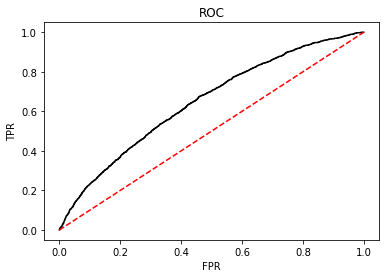

In [76]:
fpr,tpr,thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

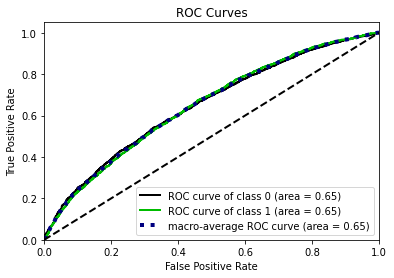

In [77]:
skplt.metrics.plot_roc(y_test, gnb.predict_proba(X_test), plot_micro=False)
plt.show()

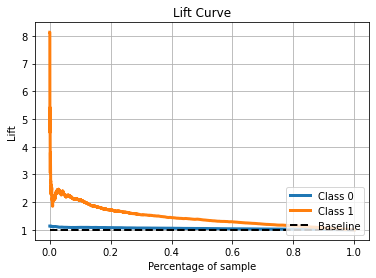

In [78]:
skplt.metrics.plot_lift_curve(y_test, gnb.predict_proba(X_test))
plt.show()

# Training Time of Models

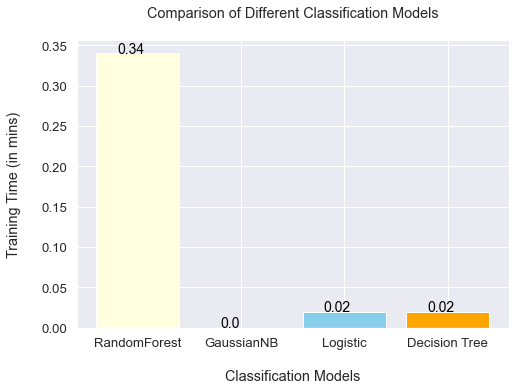

In [79]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic','Decision Tree']
TrainingTime=[rf_tt,nb_tt,lr_tt,dt_tt]
ax.bar(Models,TrainingTime,color=["lightyellow","lightgreen", "skyblue","orange"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models\n');
plt.ylabel('Training Time (in mins)\n');
plt.xlabel('\nClassification Models');
plt.show();

# Combined Results

In [80]:
Result.columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"]
Result

,Model,Accuracy Score,F1 Score,Precision Score,Recall Score,AUC,Kappa Score
0,Decision Tree,0.88984,0.340443,0.645412,0.231198,70.179997,0.294694
1,Random Forest,0.877167,0.002226,1.0,0.001114,73.239536,0.001953
2,Logistic Regression,0.87703,0.0,0.0,0.0,61.889842,0.0
3,Naive Bayes,0.645338,0.272995,0.182501,0.541504,64.808532,0.109122


# ---------------------------------------------------------------------------------------------------------------

# Modeling With Feature Selection

# Feature Selection

In [81]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

<AxesSubplot:>

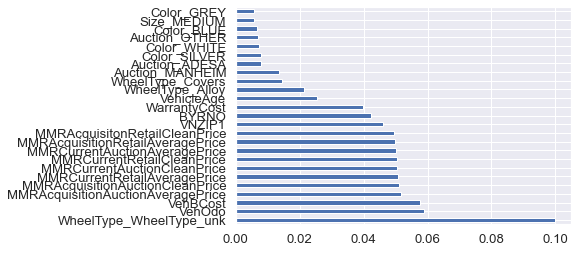

In [82]:
feat_importances = pd.Series(sel.estimator_.feature_importances_ , index= X_train.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [83]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [84]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

18

In [85]:
print(selected_feat)

Index(['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost',
       'WarrantyCost', 'Auction_MANHEIM', 'WheelType_Alloy',
       'WheelType_Covers', 'WheelType_WheelType_unk'],
      dtype='object')


In [86]:
train_new = X_train[['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost',
       'WarrantyCost', 'Auction_MANHEIM', 'WheelType_Alloy',
       'WheelType_Covers', 'WheelType_WheelType_unk']]
test_new=X_test[['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost',
       'WarrantyCost', 'Auction_MANHEIM', 'WheelType_Alloy',
       'WheelType_Covers', 'WheelType_WheelType_unk']]

In [87]:
Result_new = pd.DataFrame(columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"])
#Result = Result.astype({'Accuracy Score': np.float,'F1 Score': np.float,'Precision Score': np.float,'Recall Score': np.float,'AUC': np.float,'Kappa Score': np.float,})
Result_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Model            0 non-null      object
 1   Accuracy Score   0 non-null      object
 2   F1 Score         0 non-null      object
 3   Precision Score  0 non-null      object
 4   Recall Score     0 non-null      object
 5   AUC              0 non-null      object
 6   Kappa Score      0 non-null      object
dtypes: object(7)
memory usage: 0.0+ bytes


# Decision Tree

In [88]:
start=time.time()
tree=DecisionTreeClassifier(max_depth=12,random_state=42)
tree.fit(train_new, y_train)
stop=time.time()
dt_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {dt_tt_new}min")

Training time: 0.02min


In [89]:
y_pred_dt_new = tree.predict(test_new)

In [90]:
#Confusion Matrix
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_dt_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12560,242
True[1],1372,423


In [91]:
#Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred_dt_new))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12802
           1       0.64      0.24      0.34      1795

    accuracy                           0.89     14597
   macro avg       0.77      0.61      0.64     14597
weighted avg       0.87      0.89      0.87     14597



In [92]:
y_pred_p_dt_new = tree.predict_proba(test_new)
y_pred_p_dt_new = y_pred_p_dt_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_dt_new)

Accuracy=metrics.accuracy_score(y_test, y_pred_dt_new)
F1_Score=metrics.f1_score(y_test, y_pred_dt_new)
precision= metrics.precision_score(y_test, y_pred_dt_new)
recall=metrics.recall_score(y_test, y_pred_dt_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_dt_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 0, values=['Decision Tree',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8894293347948209
F1 Score: 0.34390243902439027
Precision Score: 0.6360902255639098
Recall Score: 0.23565459610027856
AUC: 68.96%
Kappa Score: 0.2971758528241919


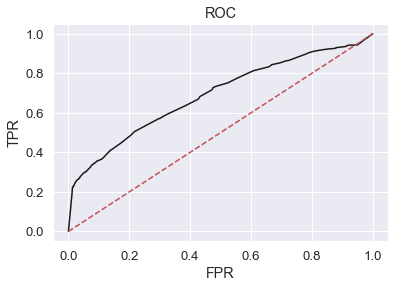

In [93]:
fpr,tpr,thresholds = roc_curve(y_test, tree.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

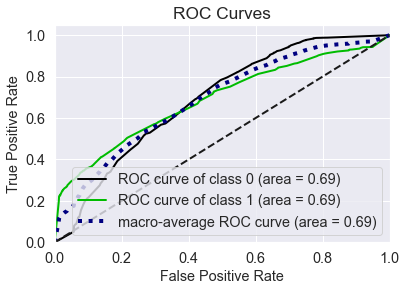

In [94]:
skplt.metrics.plot_roc(y_test, tree.predict_proba(test_new), plot_micro=False)
plt.show()

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

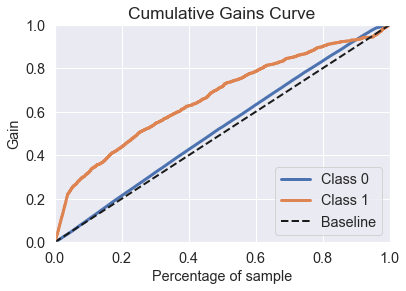

In [95]:
skplt.metrics.plot_cumulative_gain(y_test, tree.predict_proba(test_new))

# Random Forest Classifier

In [96]:
start=time.time()
forest = RandomForestClassifier( max_depth = 4, n_estimators = 500)
forest.fit(train_new, y_train)
stop=time.time()
rf_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {rf_tt_new}min")

Training time: 0.51min


In [97]:
y_pred_rc_new = forest.predict(test_new)

In [98]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_rc_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],12722,80
True[1],1412,383


In [99]:
#Classification Report
print('Classification Report of Random Forest Classifier')
print(classification_report(y_test, y_pred_rc_new))

Classification Report of Random Forest Classifier
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12802
           1       0.83      0.21      0.34      1795

    accuracy                           0.90     14597
   macro avg       0.86      0.60      0.64     14597
weighted avg       0.89      0.90      0.87     14597



In [100]:
y_pred_p_rc_new = forest.predict_proba(test_new)
y_pred_p_rc_new = y_pred_p_rc_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_rc_new)

Accuracy=metrics.accuracy_score(y_test, y_pred_rc_new)
F1_Score=metrics.f1_score(y_test, y_pred_rc_new)
precision= metrics.precision_score(y_test, y_pred_rc_new)
recall=metrics.recall_score(y_test, y_pred_rc_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_rc_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 1, values=['Random Forest',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8977872165513462
F1 Score: 0.33923826395039863
Precision Score: 0.8272138228941684
Recall Score: 0.21337047353760447
AUC: 72.86%
Kappa Score: 0.3041464565496116


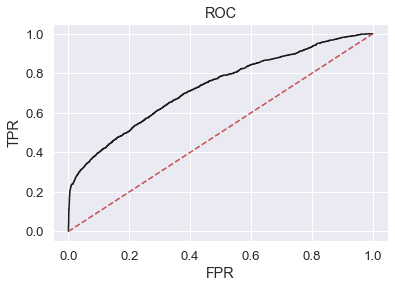

In [101]:
fpr,tpr,thresholds = roc_curve(y_test, forest.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

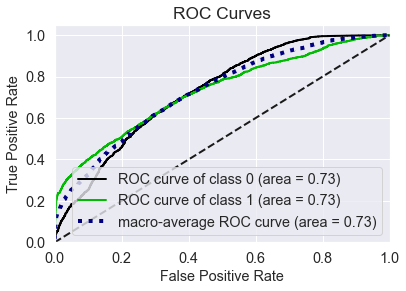

In [102]:
skplt.metrics.plot_roc(y_test, forest.predict_proba(test_new), plot_micro=False)
plt.show()

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

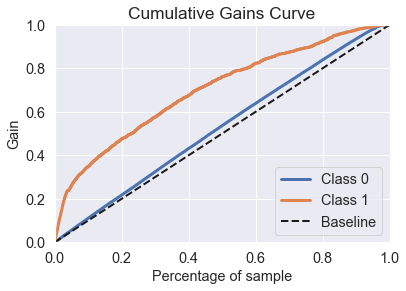

In [103]:
skplt.metrics.plot_cumulative_gain(y_test, forest.predict_proba(test_new))

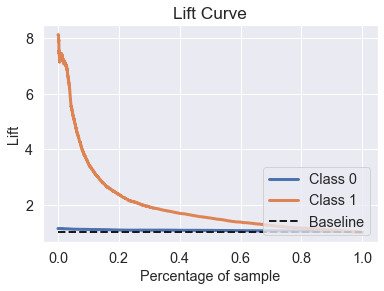

In [104]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(test_new))
plt.show()

# Logistic Regression

In [105]:
start=time.time()
logistic = LogisticRegression(solver = 'liblinear', penalty = 'l2',C =0.001, random_state = 1)
logistic.fit(train_new, y_train)
stop=time.time()
lr_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {lr_tt_new}min")

Training time: 0.01min


In [106]:
y_pred_lr_new = logistic.predict(test_new)

In [107]:
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_lr_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12802,0
True[1],1795,0


In [108]:
#Classification Report
print('Classification Report of Logistic Regression')
print(classification_report(y_test, y_pred_lr_new))

Classification Report of Logistic Regression
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12802
           1       0.00      0.00      0.00      1795

    accuracy                           0.88     14597
   macro avg       0.44      0.50      0.47     14597
weighted avg       0.77      0.88      0.82     14597



In [109]:
y_pred_p_lr_new = logistic.predict_proba(test_new)
y_pred_p_lr_new = y_pred_p_lr_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_lr_new)


Accuracy=metrics.accuracy_score(y_test, y_pred_lr_new)
F1_Score=metrics.f1_score(y_test, y_pred_lr_new)
precision= metrics.precision_score(y_test, y_pred_lr_new)
recall=metrics.recall_score(y_test, y_pred_lr_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_lr_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 2, values=['Logistic Regression',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8770295266150578
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
AUC: 61.91%
Kappa Score: 0.0


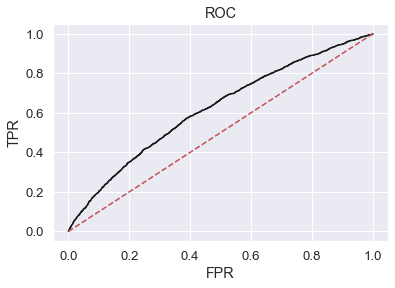

In [110]:
fpr,tpr,thresholds = roc_curve(y_test, logistic.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

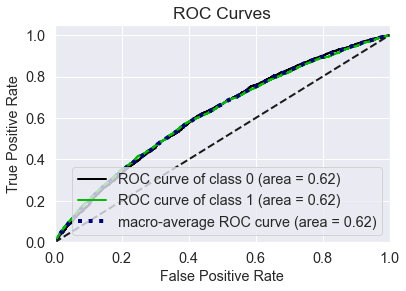

In [111]:
skplt.metrics.plot_roc(y_test, logistic.predict_proba(test_new), plot_micro=False)
plt.show()

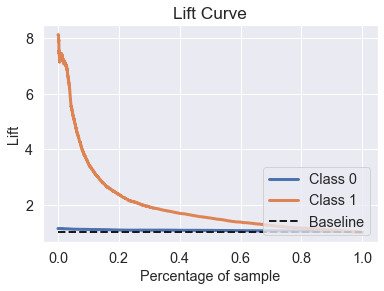

In [112]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(test_new))
plt.show()

# Naive Bayes

In [113]:
start=time.time()
gnb= GaussianNB(priors = [0.5,0.5])
gnb.fit(train_new, y_train)
stop=time.time()
nb_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {nb_tt_new}min")

Training time: 0.0min


In [114]:
y_pred_gnb_new = gnb.predict(test_new)

In [115]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_gnb_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],8466,4336
True[1],834,961


In [116]:
#Classification Report
print('Classification Report of Naive Bayes Classifier')
print(classification_report(y_test, y_pred_gnb_new))

Classification Report of Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.91      0.66      0.77     12802
           1       0.18      0.54      0.27      1795

    accuracy                           0.65     14597
   macro avg       0.55      0.60      0.52     14597
weighted avg       0.82      0.65      0.71     14597



In [117]:
y_pred_p_gnb_new = gnb.predict_proba(test_new)
y_pred_p_gnb_new = y_pred_p_gnb_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_gnb)

Accuracy=metrics.accuracy_score(y_test, y_pred_gnb_new)
F1_Score=metrics.f1_score(y_test, y_pred_gnb_new)
precision= metrics.precision_score(y_test, y_pred_gnb_new)
recall=metrics.recall_score(y_test, y_pred_gnb_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_gnb_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 3, values=['Naive Bayes',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.6458176337603617
F1 Score: 0.27100958826847155
Precision Score: 0.18142344723428355
Recall Score: 0.5353760445682452
AUC: 64.81%
Kappa Score: 0.10696562056516579


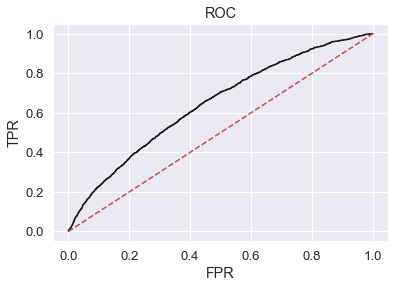

In [118]:
fpr,tpr,thresholds = roc_curve(y_test, gnb.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

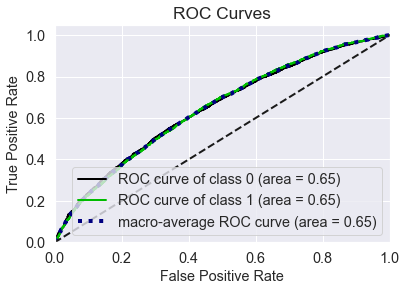

In [119]:
skplt.metrics.plot_roc(y_test, gnb.predict_proba(test_new), plot_micro=False)
plt.show()

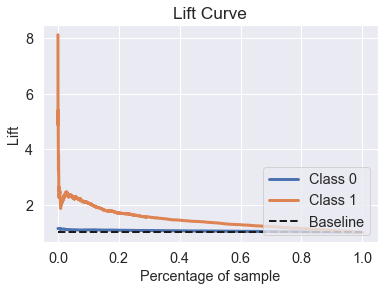

In [120]:
skplt.metrics.plot_lift_curve(y_test, gnb.predict_proba(test_new))
plt.show()

# Training Time of Models With Feature Selection

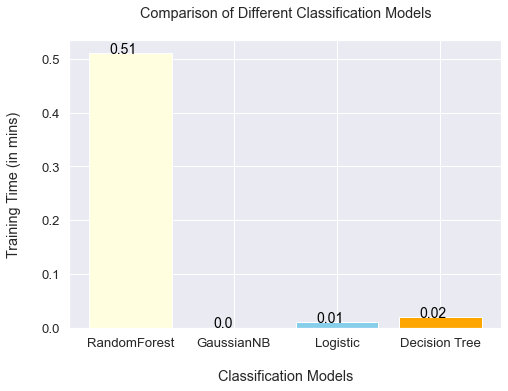

In [121]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic','Decision Tree']
TrainingTime=[rf_tt_new,nb_tt_new,lr_tt_new,dt_tt_new]
ax.bar(Models,TrainingTime,color=["lightyellow","lightgreen", "skyblue","orange"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models\n');
plt.ylabel('Training Time (in mins)\n');
plt.xlabel('\nClassification Models');
plt.show();

# Combined Results With Feature Selection

In [122]:
Result_new.columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"]
Result_new

,Model,Accuracy Score,F1 Score,Precision Score,Recall Score,AUC,Kappa Score
0,Decision Tree,0.889429,0.343902,0.63609,0.235655,68.963073,0.297176
1,Random Forest,0.897787,0.339238,0.827214,0.21337,72.85682,0.304146
2,Logistic Regression,0.87703,0.0,0.0,0.0,61.909612,0.0
3,Naive Bayes,0.645818,0.27101,0.181423,0.535376,64.808532,0.106966
